### Import packages

In [13]:
from vrpy import VehicleRoutingProblem
import networkx as nx
import math
import matplotlib.pyplot as plt
import random
import osmnx as ox
import geopandas as gpd
import folium

### Load barrios y puntos CID

In [ ]:
barrios = gpd.read_file("barrios/barris-barrios.shp")
vias = gpd.read_file("openstreet/open-valencia-edges.shp")
puntos_carga = gpd.read_file("zonas-carrega-descarrega/zones-carrega-descarrega-zonas-carga-descarga.shp")
bajos = gpd.read_file("portals-dels-carrers-portales-de-las-calles.geojson") 

### Functions

In [56]:
def get_neighbourhood(request):
    shp_neighbourhood = barrios[barrios["nombre"].str.upper() == request.upper()]
    while len(shp_neighbourhood) != 1:
        request = input("Please, introduce a valid neighbourhood: ")
        shp_neighbourhood = barrios[barrios["nombre"].str.upper() == request.upper()]
    shp_zone = shp_neighbourhood["geometry"].values[0]
    shp_loading_points = puntos_carga[puntos_carga.intersects(shp_zone)]
    return shp_zone, shp_loading_points

def get_street_network(shp_zone, vehicle=True, pedestrian=True):
    G = ox.graph_from_polygon(shp_zone, 
                              network_type="all",  
                              simplify=True, 
                              retain_all=True,  
                              truncate_by_edge=True) 
    not_highway = ['elevator', 'busway', 'corridor', 'unclassified', 'services', 'cycleway', 'steps']
    allowed_vehicle = ['motorway', 'residential', 'secondary', 'living_street',
                    'primary_link', 'primary', 'tertiary', 'trunk', 'service',
                    'tertiary_link', 'trunk_link', 'secondary_link', 'motorway_link', 'road']
    allowed_pedestrian = ["pedestrian", "footway", "path", "track", "bridleway"]
    edges_to_remove = [(u, v, k) for u, v, k, data in G.edges(keys=True, data=True) 
                   if data.get('highway') in not_highway or data.get('access') in ['yes', 'permissive', 'destination', 'customers']]
    G.remove_edges_from(edges_to_remove)

    if not vehicle:
        edges_to_remove = [(u, v, k) for u, v, k, data in G.edges(keys=True, data=True) 
                   if data.get('highway') in allowed_vehicle]
        G.remove_edges_from(edges_to_remove)
    
    if not pedestrian:
        edges_to_remove = [(u, v, k) for u, v, k, data in G.edges(keys=True, data=True) 
                   if data.get('highway') not in allowed_pedestrian]
        G.remove_edges_from(edges_to_remove)

    nodes_to_remove = [node for node in G.nodes if G.degree(node) == 0]
    G.remove_nodes_from(nodes_to_remove)
    
    return G

def get_graph(zone, vehicle=True, pedestrian=True):
    shp_zone, shp_loading_points = get_neighbourhood(zone)
    G = get_street_network(shp_zone, vehicle, pedestrian)
    
    edge_colors = []
    for u, v, k, data in G.edges(keys=True, data=True):
        if data.get('highway') in ['pedestrian', 'footway', 'path', 'track', 'bridleway']:
            edge_colors.append('red')
        else:
            edge_colors.append('blue')
    
    node_colors = ['green' for _ in G.nodes]
    
    fig, ax = ox.plot_graph(G, node_size=1, node_color=node_colors, edge_linewidth=0.5, edge_color=edge_colors, bgcolor="white")
    
    return fig, ax, shp_loading_points, shp_zone

def add_legend(mapa):
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 270px; height: 130px; 
                background-color: white; z-index:9999; font-size:14px;
                border-radius: 5px; padding: 7px; box-shadow: 2px 2px 5px rgba(0,0,0,0.3);">
        <b> Leyend </b> <br>
        <i class="fa fa-minus" style="color:blue"></i> <strong>Model 1 & 2</strong> <br>
        <i class="fa fa-minus" style="color:red"></i> <strong>Model  3</strong> <br>
        <i class="fa fa-square" style="color:limegreen"></i> <strong>Neighbourhood</strong>  <br>
        <i class="fa fa-circle" style="color:orange"></i> <strong>Loading points</strong> <br>
        <i class="fa fa-circle" style="color:purple"></i> <strong>Delivery points</strong> <br>
    </div>
    '''
    mapa.get_root().html.add_child(folium.Element(legend_html))
    
def combined(shp_street, shp_zone, shp_loading_points, bajos):
    mapa = folium.Map(location=[shp_zone.centroid.y, shp_zone.centroid.x], zoom_start=16)
    shp_street = shp_street[shp_street.intersects(shp_zone)]
    bajos_in_zone = bajos[bajos.intersects(shp_zone)]
    

    for _, row in shp_street.iterrows():
        if row["geometry"].geom_type == "LineString":
            puntos = [(p[1], p[0]) for p in row["geometry"].coords]
            color = "red" if row["Model3"] else "blue"
            folium.PolyLine(puntos, weight=2, opacity=1, color=color).add_to(mapa)

    folium.GeoJson(
        shp_zone,  
        style_function=lambda feature: {
            "color": "green", 
            "weight": 6,  
            "fill": True,  
            "fillColor": "limegreen",  
            "fillOpacity": 0.2  
        }
    ).add_to(mapa)

    shp_loading_points.apply(lambda row: folium.CircleMarker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x], 
        radius=6,  
        color="orange",  
        fill=True,
        fill_color="black",  
        fill_opacity=1, 
        popup=row.get("NOMBRE", "Punto de carga")
    ).add_to(mapa), axis=1)

    for i, (_, row) in enumerate(bajos_in_zone.iterrows()):
        if i % 20 == 0:
            folium.CircleMarker(
                location=[row.geometry.y, row.geometry.x],
                radius=6,  # Radio del círculo
                color='cyan',  # Color del borde
                fill=True,
                fill_color='purple',  # Color de relleno
                fill_opacity=1,
                popup=row.get("descripcion", "Bajo")
            ).add_to(mapa)
    
    add_legend(mapa)
    

    return mapa

### Get the graph

| FAVARA               | BENICALAP             | SANT PAU                 | BORBOTO                  | BENIFARAIG               |
|----------------------|----------------------|--------------------------|--------------------------|--------------------------|
| CAMI REAL           | JAUME ROIG            | LA SEU                   | AIORA                    | TORMOS                   |
| LA FONTETA S.LLUIS  | LA PETXINA            | L'HORT DE SENABRE        | CIUTAT JARDI             | CAMI DE VERA             |
| LA PUNTA            | SANT MARCEL.LI        | FAITANAR                 | PINEDO                   | CASTELLAR-L'OLIVERAL     |
| BENIMAMET           | EL FORN D'ALCEDO      | MONTOLIVET               | CIUTAT DE LES ARTS I DE LES CIENCIES | NA ROVELLA             |
| SANT LLORENS        | NATZARET              | LA CREU COBERTA          | L'AMISTAT                | EL GRAU                  |
| CIUTAT FALLERA      | RAFALELL-VISTABELLA   | LA CARRASCA              | BENIFERRI                | EL SALER                 |
| NOU MOLES           | MORVEDRE              | TRINITAT                 | CAMPANAR                 | EL CARME                 |
| LA LLUM             | LA VEGA BAIXA         | LA XEREA                 | L'ILLA PERDUDA           | TRES FORQUES             |
| LA MALVA-ROSA       | EL MERCAT             | LA ROQUETA               | LA GRAN VIA              | CAMI FONDO               |
| EL CALVARI          | LA RAIOSA             | SAFRANAR                 | SANT ISIDRE              | MALILLA                  |
| LES TENDETES        | PATRAIX               | RUSSAFA                  | LA CREU DEL GRAU         | LES CASES DE BARCENA     |
| CIUTAT UNIVERSITARIA | MAHUELLA-TAULADELLA  | MASSARROJOS              | CARPESA                  | TORREFIEL                |
| EL BOTANIC          | SANT ANTONI           | BENIMACLET               | MARXALENES               | EXPOSICIO                |
| BETERO              | CABANYAL-CANYAMELAR   | MESTALLA                 | EL PILAR                 | EL PLA DEL REMEI         |
| ALBORS              | ARRANCAPINS           | EN CORTS                 | POBLE NOU                | LA TORRE                 |
| SANT FRANCESC       | PENYA-ROJA            | ELS ORRIOLS              | VARA DE QUART            | SOTERNES                 |
| LA FONTSANTA        | EL PERELLONET         | EL PALMAR                | LA XEREA                 | L'ILLA PERDUDA           |


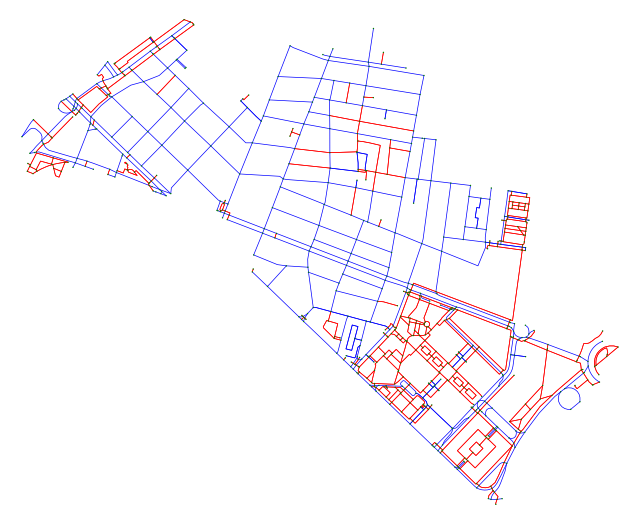

In [51]:
fig, ax, shp_loading_points, shp_zone = get_graph('benimaclet')
plt.show()
combined(vias, shp_zone, shp_loading_points, bajos)